In [1]:
pip install xgboost scikit-learn==1.3.0


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight


In [4]:
# Load the dataset
df = pd.read_csv('/Users/sumee/Downloads/predictive_maintenance.csv')

# Inspect the first few rows
df.head()


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [15]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [16]:
X = df.iloc[:, 2:8]  
y = df.iloc[:, -1]   

# Ordinal encoding for 'Type' column
oe = OrdinalEncoder(categories=[['L', 'M', 'H']])
X['Type'] = oe.fit_transform(X[['Type']]).astype(int)


In [17]:
# Custom categories for the target variable
categories = ['No Failure', 'Heat Dissipation Failure', 'Power Failure', 'Overstrain Failure', 'Tool Wear Failure', 'Random Failures']
custom_encoder = {cat: i for i, cat in enumerate(categories)}

# Encode target using the custom mapping
y_encoded = [custom_encoder.get(cat, len(categories)) for cat in y]

# Label encoding the target variable
le = LabelEncoder()
y = le.fit_transform(y_encoded)


In [18]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [19]:
X_train.columns = X_train.columns.str.replace(r"[\[\]]", "", regex=True)
X_test.columns = X_test.columns.str.replace(r"[\[\]]", "", regex=True)

In [20]:
# Calculate class weights to handle imbalance
class_weights = class_weight.compute_sample_weight('balanced', y_train)


In [21]:
# Check feature names in X_train
print(X_train.columns)


Index(['Type', 'Air temperature K', 'Process temperature K',
       'Rotational speed rpm', 'Torque Nm', 'Tool wear min'],
      dtype='object')


In [22]:
# Initialize XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Cross-validation for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train, sample_weight=class_weights)


Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [23]:
# Display the best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")


Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


In [24]:
# Train the XGBoost model with the best parameters
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train, sample_weight=class_weights)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [25]:
# Predict on test set
y_pred = best_xgb.predict(X_test)

# Calculate accuracy and classification report
xgb_accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f"XGBoost Model Accuracy: {xgb_accuracy}%")

# Confusion Matrix and Classification Report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=categories))


XGBoost Model Accuracy: 98.25%
Confusion Matrix:
[[1913    4    2    1    9    1]
 [   0   22    0    0    0    0]
 [   3    0   16    0    0    0]
 [   2    0    1   13    0    0]
 [   7    0    0    1    1    0]
 [   3    0    0    0    1    0]]
Classification Report:
                          precision    recall  f1-score   support

              No Failure       0.99      0.99      0.99      1930
Heat Dissipation Failure       0.85      1.00      0.92        22
           Power Failure       0.84      0.84      0.84        19
      Overstrain Failure       0.87      0.81      0.84        16
       Tool Wear Failure       0.09      0.11      0.10         9
         Random Failures       0.00      0.00      0.00         4

                accuracy                           0.98      2000
               macro avg       0.61      0.63      0.61      2000
            weighted avg       0.98      0.98      0.98      2000



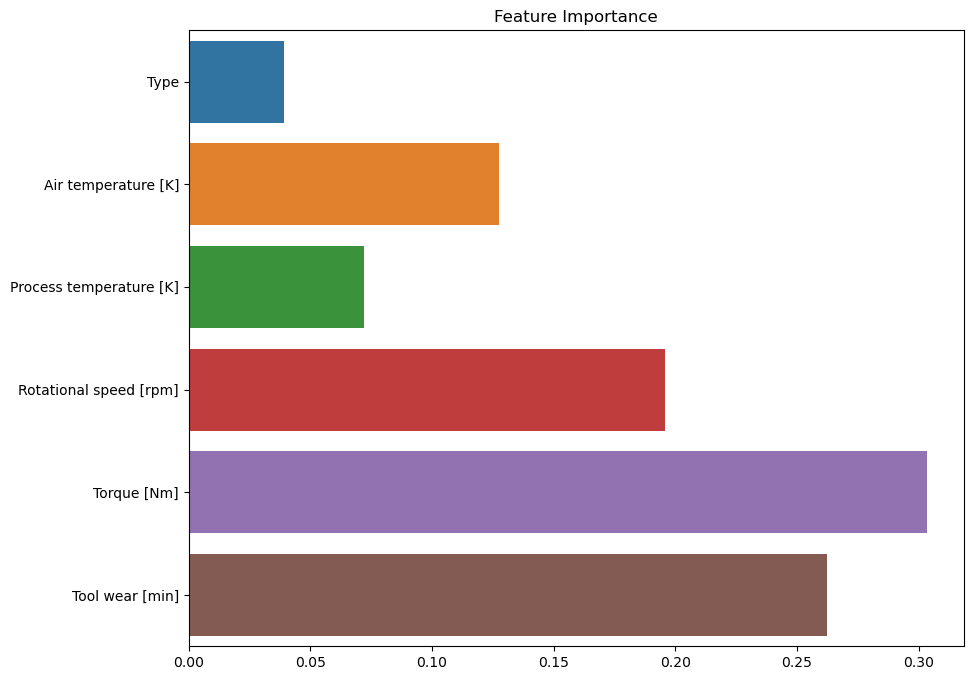

In [26]:
# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x=best_xgb.feature_importances_, y=X.columns)
plt.title("Feature Importance")
plt.show()


In [27]:
# Training Accuracy
xgb_train_accuracy = round(best_xgb.score(X_train, y_train) * 100, 2)
print(f"Training Accuracy: {xgb_train_accuracy}%")

# Model Accuracy
print(f"Test Accuracy: {xgb_accuracy}%")

# Detailed classification report
print("Detailed Classification Report:\n", classification_report(y_test, y_pred, target_names=categories))


Training Accuracy: 99.94%
Test Accuracy: 98.25%
Detailed Classification Report:
                           precision    recall  f1-score   support

              No Failure       0.99      0.99      0.99      1930
Heat Dissipation Failure       0.85      1.00      0.92        22
           Power Failure       0.84      0.84      0.84        19
      Overstrain Failure       0.87      0.81      0.84        16
       Tool Wear Failure       0.09      0.11      0.10         9
         Random Failures       0.00      0.00      0.00         4

                accuracy                           0.98      2000
               macro avg       0.61      0.63      0.61      2000
            weighted avg       0.98      0.98      0.98      2000



In [30]:
# Save the model
import joblib
joblib.dump(best_xgb, "c:/Users/sumee/Desktop/xgboost_model.pkl")

['c:/Users/sumee/Desktop/xgboost_model.pkl']